In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from pprint import pprint

import src
from src.reload import deep_reload

In [13]:
'''
Creating a random graph

graph contains n destinations and m chargers

the random graph is completely connected
'''
deep_reload(src)

seed = 125396749
n = 15
m = 85
speeds = [105]
chargers = list(range(10))
scale = (1e6, 1e6)

graph = src.rng.random_completely_connected_graph(
    n, m, speeds = speeds, scale = scale, seed = seed, chargers = chargers,
)

graph = src.routing.edge_types(graph)

destinations = [k for k, v in graph._node.items() if v['type'] is 'place']

In [3]:
graph.number_of_nodes(), graph.number_of_edges()

(100, 5050)

In [6]:
'''
Running with Bellman with default objective
'''
deep_reload(src)

objective = src.routing.Scout(field = 'distance', edge_limit = 200e3)

t0 = time.time()

costs, values, paths = src.routing.shortest_paths(
    graph, ['destination_0'],
    objective = objective,
    return_paths = True,
    method = 'bellman'
)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 0.0099 seconds


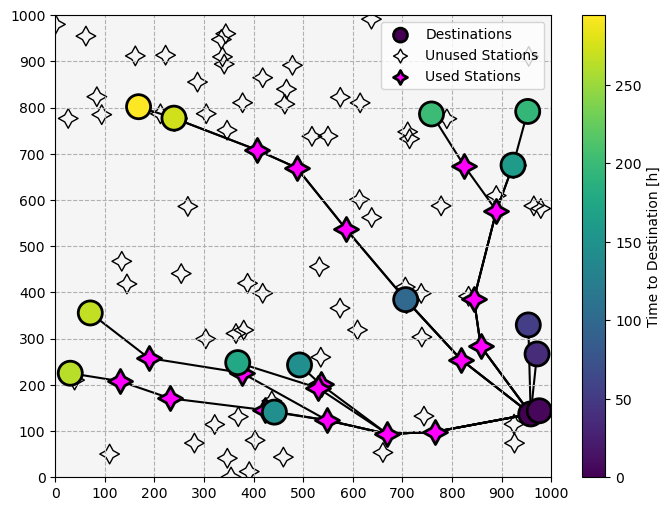

In [8]:
deep_reload(src)

fig, ax = plt.subplots(figsize = (8, 6))

destinations = [k for k, v in graph._node.items() if v['type'] is 'destination']

kw = src.figures.default_route_tree_kwargs

color = (254 / 255, 214 / 255, 1 / 255)

src.figures.plot_route_tree(
    ax, graph,
    values = {k: v / 3600 for k, v in values.items()},
    paths = {k: v for k, v in paths.items() if graph._node[k]['type'] is 'destination'},
    destinations = destinations,
    # show_used_stations = False,
    **kw,
)

_ = ax.set(**{
    'xticks': np.linspace(-5e5, 5e5, 11),
    'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'xlim': (-5e5, 5e5),
    'yticks': np.linspace(-5e5, 5e5, 11),
    'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'ylim': (-5e5, 5e5),
    'facecolor': 'whitesmoke',
})

legend = ax.legend()

for h in legend.legendHandles:
    h._sizes = [100]

    ax.grid(ls = '--')

In [14]:
deep_reload(src)

seed = 1468952
seed = None
rng = np.random.default_rng(seed)

vehicle_param = src.experiments._vehicle_kwargs
station_param = src.experiments._station_kwargs
graphs = [0]

graph_index, vehicle_kw, station_kw = src.experiments.generate_case(
    graphs, vehicle_param, station_param, rng,
)

graph_index, vehicle_kw, station_kw

(0,
 {'capacity': 211095700.4313651,
  'power': 69076.03891865628,
  'risk_attitude': array([0.52718922, 0.72718922]),
  'cases': 1,
  'soc_bounds': (0.1, 1),
  'efficiency': 550,
  'linear_fraction': 0.8},
 {'place': {'cases': 100,
   'type': 'ac',
   'access': 'private',
   'price': 1.1111111111111112e-07,
   'setup_time': 0,
   'rng': Generator(PCG64) at 0x7F87CC6A7300},
  'station': {'reliability': 0.9732193492341634,
   'cases': 100,
   'type': 'dc',
   'access': 'public',
   'power': {'Tesla': [250000.0],
    'Electrify America': [150000.0],
    'ChargePoint Network': [62500.0],
    'eVgo Network': [50000.0, 100000.0, 350000.0],
    'default': [50000.0]},
   'price': 1.3888888888888888e-07,
   'setup_time': 300,
   'rng': Generator(PCG64) at 0x7F87CC6A7300}})

In [11]:
vehicle_kw['risk_attitude'] = (.8, 1)
vehicle_kw['capacity'] = 40 * 3.6e6
station_kw['station']['reliability'] = .5 + .5

In [15]:
deep_reload(src)

t0 = time.time()

costs, values, paths = src.experiments.run_case(
    graph, vehicle_kw, station_kw, method = 'dijkstra'
)

print(f'\n\nExecuted in {time.time() - t0:.4f} seconds')



Executed in 0.7580 seconds


In [25]:
src.routing.impedance(
    values, field = 'routing_time',
) / 3600

3.3909769334587447

In [142]:
src.routing.impedance(
    values, field = 'total_time',
) / 3600

7.704711236725918

In [26]:
src.routing.impedance(
    values, field = 'driving_time',
) / 3600

1.4660880559309393